## Learning Lyapunov function for Inverted Pendulum

In [1]:
# -*- coding: utf-8 -*-
# from dreal import *
from Functions import *
import torch 
import torch.nn.functional as F
import numpy as np
import timeit 
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os

import gymnasium as gym
from gym.envs.classic_control import PendulumEnv
from stable_baselines3 import DDPG
from stable_baselines3.common.env_util import DummyVecEnv
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\dell\anaconda3\envs\tf115\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Neural network model
Building NN with random parameters for Lyapunov function and initializing parameters of NN controller to LQR solution

LQR solution is obtained by minimizing the cost function J = ∫(xᵀQx + uᵀRu)dt, where Q is 2×2 identity matrix and R is 1×1 identity matrix

In [2]:
class Net(torch.nn.Module):
    
    def __init__(self,n_input,n_hidden,n_output):
        super(Net, self).__init__()
        torch.manual_seed(2)
        self.layer1 = nn.Linear(n_input, n_hidden)
        self.layer2 = nn.Linear(n_hidden,n_output)
        # self.control = torch.nn.Linear(n_input,1,bias=False)
        # self.control.weight = torch.nn.Parameter(lqr)

    def forward(self,x):
        sigmoid = nn.Tanh()
        h_1 = sigmoid(self.layer1(x))
        out = sigmoid(self.layer2(h_1))
        # u = self.control(x)
        return out
    
class NeuralNetwork(nn.Module):
    def __init__(self, input_size=2, output_size=1):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Input size: 3 (3D float input), Output size: 64
        self.fc2 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, output_size)  # Output size: 1 (1D float output)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc6(x)
        return x

## Policy model

In [3]:
# Create the Pendulum-v1 environment
env = PendulumEnv()
policy_model = DDPG.load("ddpg_pendulum_10k")

## Dynamical system

In [4]:
dynamic_model = NeuralNetwork(3,2)
dynamic_model.load_state_dict(torch.load('model_2_NN2.pth'))

<All keys matched successfully>

## Options

In [113]:
'''
For learning 
'''
N = 10000             # sample size
N_test = 10
D_in = 2            # input dimension
H1 = 6              # hidden dimension
D_out = 1           # output dimension
dt = 0.05
torch.manual_seed(10)
# x_ = torch.Tensor(N, D_in).uniform_(-6, 6)
x1 = torch.Tensor(N, 1).uniform_(-np.pi, np.pi)
x2 = torch.Tensor(N, 1).uniform_(-2,2)
x = torch.cat((x1, x2), dim=1)
x_obs = torch.cat((np.cos(x[:,0]).reshape(-1,1), np.sin(x[:,0]).reshape(-1,1), x[:,1].reshape(-1,1)), dim=1)
x_0 = torch.zeros([1, 2])

epsilon = 0
# Checking candidate V within a ball around the origin (ball_lb ≤ sqrt(∑xᵢ²) ≤ ball_ub)
ball_lb = 0.5
ball_ub = 74

## Learning and Falsification

The dynamics of an inverted pendulum
$$\ddot{\theta}(t) = \frac{mgl \sin(\theta(t)) + u(t)}{m l^2},$$
where $m$ is the mass, $g$ the gravitational constant, $l$ the length of the pendulum, $u$ the control input (torque), and $\theta$ the angle.
accelerte = $\Delta$ velocity / dt, where dt = 0.05

In [148]:
out_iters = 0
valid = False
model = Net(D_in,H1, D_out)
model.load_state_dict(torch.load('LNN_tune_1x0.pth'))
while out_iters < 5 and not valid:
    start = timeit.default_timer()
    # lqr = torch.tensor([[-23.58639732,  -5.31421063]])    # lqr solution
    
    L = []
    i = 0
    t = 0
    max_iters = 20000
    learning_rate = 0.01
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    while i < max_iters and not valid: 
        V_candidate = model(x)
        X0 = model(x_0)
        u, _ = policy_model.predict(x_obs)
        # print("input", torch.cat((x,torch.from_numpy(u)), dim=1).size())
        next_state = dynamic_model(torch.cat((x,torch.from_numpy(u)), dim=1))
        accelerate = (next_state[:,1] - x[:,1]) / dt
        f = torch.stack((x[:,1], accelerate), dim=1)
        
        Circle_Tuning = Tune(x)
        # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
        L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),f.t()),0)

        # With tuning term 
        Lyapunov_risk = (F.relu(-V_candidate)+ 1.5*F.relu(L_V+0.5)).mean()\
                    +2.2*((Circle_Tuning-6*V_candidate).pow(2)).mean()+(X0).pow(2)
        # Without tuning term
        # Lyapunov_risk = (3.5*F.relu(-V_candidate)+ 1*F.relu(L_V+0.5)).mean()+ 20*(X0).pow(2)
        
        
        # print(i, "Lyapunov Risk=",Lyapunov_risk.item())
        L.append(Lyapunov_risk.item())
        optimizer.zero_grad()
        Lyapunov_risk.backward()
        optimizer.step()

        # Falsification
        if i % 10 == 0:

            print(i, "Lyapunov Risk=",Lyapunov_risk.item())
            x1_test = torch.Tensor(N_test, 1).uniform_(-np.pi, np.pi)
            x2_test = torch.Tensor(N_test, 1).uniform_(-2,2)
            x_test = torch.cat((x1_test, x2_test), dim=1)
            x_obs_test = torch.cat((np.cos(x1_test), np.sin(x1_test), x2_test), dim=1)

            V_candidate = model(x_test)
            u, _ = policy_model.predict(x_obs_test)
            next_state = dynamic_model(torch.cat((x_test,torch.from_numpy(u)), dim=1))
            accelerate = (next_state[:,1] - x_test[:,1]) / dt
            f = torch.stack((x_test[:,1], accelerate), dim=1)

            # Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
            L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                            *dtanh(torch.tanh(torch.mm(x_test,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),f.t()),0)
            # index = np.logical_and(V_candidate.reshape(-1)>0, L_V<epsilon)
            print("V:",V_candidate.detach().numpy().reshape(-1),'\nL_V:' , L_V.detach().numpy())

            # print('===========Verifying==========')
            start_ = timeit.default_timer()
            result= CheckLyapunov(x_test, f, V_candidate.reshape(-1), L_V, ball_lb, ball_ub, epsilon)
            stop_ = timeit.default_timer()

            print("unsatisfied sample number:",result.size()[0],"/",N_test)
            if (result.size()[0]!=0): 
                # print("Not a Lyapunov function. Found counterexample: ")
                # print(result)
                x = AddCounterexamples(x,result,10)
                x_obs = torch.cat((np.cos(x[:,0]).reshape(-1,1), np.sin(x[:,0]).reshape(-1,1), x[:,1].reshape(-1,1)), dim=1)
                pass
            else:  
                valid = True
                print("Satisfy conditions!!")
                print(V_candidate, " is a Lyapunov function.")
            t += (stop_ - start_)
            # print('==============================')
        i += 1

    stop = timeit.default_timer()
    valid = False

    # torch.save(model.state_dict(), 'LNN_tune_1x0.pth')
    print('\n')
    print("Total time: ", stop - start)
    print("Verified time: ", t)
    
    out_iters+=1

0 Lyapunov Risk= 0.6907699704170227
V: [0.16695833 0.13175765 0.25595593 0.28135076 0.19588855 0.43685257
 0.20135532 0.18566246 0.38036558 0.08408339] 
L_V: [-0.02030988  0.1416597  -0.7517693  -0.5298292  -0.75731504 -0.61875844
 -1.0150447   0.36276385 -0.45127118  0.16364385]
unsatisfied sample number: 2 / 10


e:\Aalto\PML summer\Code\Neural-Lyapunov-Control\Functions.py:23: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/IndexingUtils.h:28.)
  return x[condition]


10 Lyapunov Risk= 0.7598092555999756
V: [0.31547382 0.27755246 0.18295857 0.10302427 0.26710194 0.30235273
 0.46321958 0.41296348 0.2846136  0.32140192] 
L_V: [-0.35123274 -0.33069748  0.2537066   0.02633051  0.01327358 -0.48092768
 -0.4101852  -0.51978016 -0.3164158  -0.46605614]
unsatisfied sample number: 2 / 10
20 Lyapunov Risk= 0.7019277215003967
V: [0.08845648 0.21449445 0.41218358 0.18598214 0.34987828 0.49213365
 0.5200459  0.2791026  0.20873305 0.1444929 ] 
L_V: [ 0.06300475  0.02921952 -0.34191602  0.14696023 -0.5930978  -0.62583107
 -0.3900822  -0.7409019   0.1006552   0.13886584]
unsatisfied sample number: 4 / 10
30 Lyapunov Risk= 0.6911376714706421
V: [0.29221645 0.21376067 0.32131153 0.33190024 0.33038193 0.12743482
 0.4409834  0.45251915 0.15539367 0.32157904] 
L_V: [-0.22215171 -0.10528037 -0.7119842  -0.8332393  -0.3892174   0.30956623
 -0.48232898 -0.54289985  0.35649315 -0.6266846 ]
unsatisfied sample number: 2 / 10
40 Lyapunov Risk= 0.6923252940177917
V: [0.21307044 

In [144]:
torch.save(model.state_dict(), 'LNN_tune_1x0.pth')

torch.Size([100000, 2]) torch.Size([100000, 1])
[0.08482511 0.0848286  0.08483002 0.08484209 0.08484615] [[-0.0751586  -0.06097102]
 [-0.07255626 -0.05923176]
 [-0.08207893 -0.06540418]
 [-0.0680089  -0.06974983]
 [-0.08452916 -0.07162523]]


tensor([0.1815], grad_fn=<TanhBackward0>)

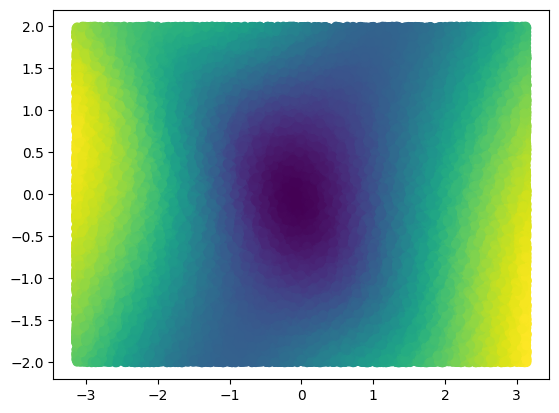

In [147]:

model.load_state_dict(torch.load('LNN_tune_1x0.pth'))
N_ = 100000
x1_ = torch.Tensor(N_, 1).uniform_(-np.pi, np.pi)
x2_ = torch.Tensor(N_, 1).uniform_(-2,2)
x_ = torch.cat((x1_, x2_), dim=1)
x_obs_ = torch.cat((np.cos(x_[:,0]).reshape(-1,1), np.sin(x_[:,0]).reshape(-1,1), x_[:,1].reshape(-1,1)), dim=1)
x_0 = torch.zeros([1, 2])
V = model(x_)
print(x_.shape, V.shape)
x_np = x_.detach().numpy()
V_np = V.detach().numpy().reshape(-1)

plt.scatter(x_np[:, 0], x_np[:, 1], c=V_np, cmap='viridis')
i = np.argsort(V_np)[:5]

print(V_np[i], x_np[i])

# torch.save(model.state_dict(), 'Lyapunov_NN_gym.pth')
model(torch.tensor([0.5,1], dtype=torch.float32))

### Checking result with smaller epsilon ( Lie derivative of V <= epsilon )

In [87]:
epsilon = -0.00001
x1_test = torch.Tensor(N_test, 1).uniform_(-np.pi, np.pi)
x2_test = torch.Tensor(N_test, 1).uniform_(-8,8)
x_test = torch.cat((x1_test, x2_test), dim=1)
x_obs_test = torch.cat((np.cos(x1_test), np.sin(x1_test), x2_test), dim=1)

V_candidate = model(x_test)
u, _ = policy_model.predict(x_obs_test)
next_state = dynamic_model(torch.cat((x_test,torch.from_numpy(u)), dim=1))
accelerate = (next_state[:,1] - x_test[:,1]) / dt
f = torch.stack((x_test[:,1], accelerate), dim=1)

# Compute lie derivative of V : L_V = ∑∂V/∂xᵢ*fᵢ
L_V = torch.diagonal(torch.mm(torch.mm(torch.mm(dtanh(V_candidate),model.layer2.weight)\
                *dtanh(torch.tanh(torch.mm(x_test,model.layer1.weight.t())+model.layer1.bias)),model.layer1.weight),f.t()),0)

start_ = timeit.default_timer() 
result = CheckLyapunov(x_test, f, V_candidate.reshape(-1), L_V, ball_lb, ball_ub, epsilon)
stop_ = timeit.default_timer()
# print(model.layer1.weight, model.layer2.weight, model.layer1.bias, model.layer2.bias)
print(result.size()[0])
if result.size()[0]>1: 
    print("Not a Lyapunov function. Found counterexample: ")
    print("V:",V_candidate)
    print("L_V",L_V)
    # print(result)
else:  
    print("Satisfy conditions with epsilon= ",epsilon)
    print(" is a Lyapunov function.")
t += (stop_ - start_)

3
Not a Lyapunov function. Found counterexample: 
V: tensor([[-0.2955],
        [ 0.3279],
        [ 0.0219],
        [ 0.6891],
        [ 0.2646],
        [ 0.3611],
        [ 0.0225],
        [ 0.4226],
        [-0.0812],
        [ 0.4017]], grad_fn=<TanhBackward0>)
L_V tensor([ 0.7574, -0.5359, -1.5154, -1.4715, -0.4418, -0.6728,  1.4068, -0.5455,
        -0.7957, -2.5923], grad_fn=<DiagonalBackward0>)


### More details on Lyapunov risk
Generally, we start training with Lyapunov risk without the tuning term.      
For example, (1* F.relu(-V_candidate)+ 1.5* F.relu(L_V+0.5)).mean()+ 1.2*(X0).pow(2)    
The weight of each term (1, 1.5, 1.2) can be tuned for balancing each Lyapunov condition.     
Furthermore, using F.relu(L_V+0.5) allows the learning procedure to seek a candidate Lyapunov function with more negative Lie derivative.   
Here 0.5 is also a tunable parameter based on your goal.    
In this example, we use Lyapunov risk with tuning term for achieving large ROA     